# imports

In [1]:
from Bio import Entrez
import requests,math,pickle,time
import networkx, obonet
import numpy as np ,pandas as pd, matplotlib.pyplot as plt
import arabic_reshaper
import multiprocessing as mp
from sklearn.metrics.cluster import *
from bidi.algorithm import get_display
from functools import partial
from IPython.display import clear_output
import sys
if sys.version_info[0] < 3: 
    from StringIO import StringIO
else:
    from io import StringIO

def fa(text):
    return get_display(arabic_reshaper.reshape(u'%s' % str(text)))

def sf(text,num):
    return text + ''.join([' ' for _ in range(num-len(text))])

In [2]:
def getTaxName(tax_id):
    Entrez.email = 'abolhasani.eliya@gmail.com'
    handle = Entrez.efetch('taxonomy', id= [str(tax_id)],rettype='xml')
    response = Entrez.read(handle)
    return response[0]

# Init

In [25]:
num_cores = max(mp.cpu_count() - 3, 1)
dataset_name = "gi"
!mkdir -p ./Output/{dataset_name}/figs
!mkdir -p ./Output/{dataset_name}/figs

In [26]:
def fasta_to_df(path):
    with open(path, 'r') as file:
        text = file.read()
    lines = [line for line in text.split('\n') if len(line) > 0]
    s = ''
    ids = []
    contigs = []
    for l in lines:
        if(l[0]=='>'):
            ids.append(l)        
            contigs.append(s)
            s = ''
        else:
            s += l    
    contigs.append(s)
    df = pd.DataFrame(
            {
                '#anonymous_gsa_id': ids,
                'contig': contigs[1:]
            })
    df['#anonymous_gsa_id'] = df['#anonymous_gsa_id'].apply(lambda x: x[1:])    
    return df

In [27]:
contigs = fasta_to_df(f"./Dataset/{dataset_name}/contigs.fna")
print(contigs.shape)
contigs.head()

(81602, 2)


,#anonymous_gsa_id,contig
0,S2C0,TACGCCGTTAAATGTATTGTTTTTGACCATCGTATAAATTGCCATA...
1,S2C4,AAATTATCAGCATCAGTAATTTGGGATGCTAGAGGATTGTCAAAAA...
2,S2C15,GTCCACACCAAAGAAAAGAATGAAAAAATCATTGTCCAACCCGAGG...
3,S2C17,GTGCAGCAGATCGCCGGGGGCCTGATGCTCGTAGCGCACCACCGGC...
4,S2C22,AAGTCAAGATAACATTTTCCTTCAGTGTCCAATAGGTACATACCTT...


##  Contigs description

In [28]:
# show description of contigs and contigs length histogram.
contigsLenght = contigs['contig'].apply(lambda x: len(x))
num = 30
print(sf('min :',num) + str(contigsLenght.min()))
print(sf('max :',num) + str(contigsLenght.max()))
print(sf('mean :',num) + str(round(contigsLenght.mean(),2)))
print(sf('median :',num) + str(round(np.median(contigsLenght),2)))
print(sf('1st quartiles',num) + str(round(np.percentile(contigsLenght, 25),2)))
print(sf('median :',num) + str(round(np.median(contigsLenght),2)))
print(sf('3rd quartiles :',num) + str(round(np.percentile(contigsLenght, 75),2)))
print(sf('standard deviation :',num) + str(round(np.std(contigsLenght),2)))
print(sf('variance :',num) + str(round(np.var(contigsLenght),2)))

#tota bp
print(sf('total bp :',num) + str(sum(contigsLenght.values)))

min :                         2000
max :                         6530223
mean :                        21091.89
median :                      3970.0
1st quartiles                 2682.0
median :                      3970.0
3rd quartiles :               7281.0
standard deviation :          198321.63
variance :                    39331468032.59
total bp :                    1721140243


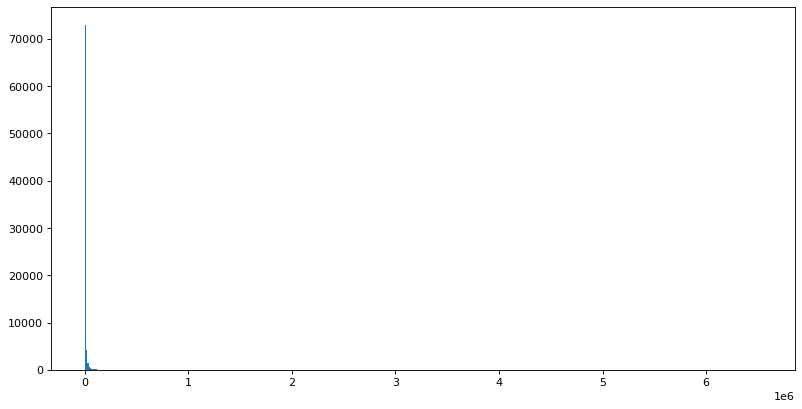

In [29]:
plt.figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
plt.hist(contigsLenght, bins=500)
plt.savefig(f"./Output/{dataset_name}/figs/histogram_contig_length.svg")
plt.savefig(f"./Output/{dataset_name}/figs/histogram_contig_length.png")
plt.show()

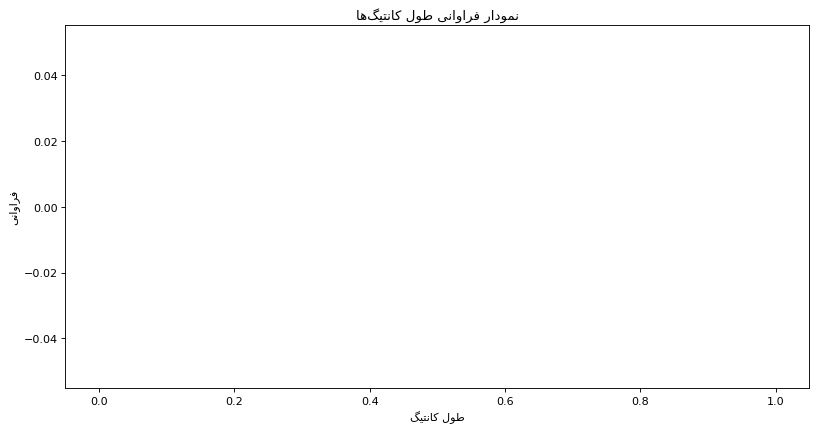

In [30]:
plt.figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
plt.hist(contigsLenght[contigsLenght < 2000], bins=100)
plt.xlabel(fa("طول کانتیگ"))
plt.ylabel(fa("فراوانی"))
plt.title(fa("نمودار فراوانی طول کانتیگ‌ها"))
plt.savefig(f"./Output/{dataset_name}/figs/histogram_lower_than_2000.svg")
plt.savefig(f"./Output/{dataset_name}/figs/histogram_lower_than_2000.png")
plt.show()

# Load gold_standard

In [31]:
# use this cell if your gold standard file needs to convert tsv format
'''with open('./Dataset/CAMI_High/gsa_mapping_pool.binning','r') as file:
    text = file.read()
    text = text.split('\n')
df = pd.read_csv(StringIO('\n'.join(text[4:])), sep="\t", header=None)                
df.columns = ['#anonymous_gsa_id','bin_id','tax_id']
df.to_csv('./Dataset/CAMI_High/mapping.tsv',index=None,sep='\t')
df.head()''';

In [32]:
path = f"./Dataset/{dataset_name}/reference.tsv"
info = pd.read_csv(path, sep='\t',header=None)
info.columns = ['#anonymous_gsa_id','OTU','Genbank Accession Number','a','b']

df = pd.read_csv(f"./Dataset/{dataset_name}/taxonomy.tsv", sep='\t',header=None)
df.columns=['OTU','Bacteria','Family']
info = pd.merge(info, df, how='inner', on='OTU')
info.head(2)

,#anonymous_gsa_id,OTU,Genbank Accession Number,a,b,Bacteria,Family
0,S0C53975,OTU_97.1070.0,CP003221.1,3409328,3413150,Desulfovibrio africanus,Desulfovibrio
1,S0C48999,OTU_97.1070.0,CP003221.1,955813,959944,Desulfovibrio africanus,Desulfovibrio


In [33]:
len(info['Bacteria'].unique())

137

In [39]:
df = pd.read_csv(f"./Dataset/{dataset_name}/mapping.tsv", sep='\t')
df.head()
contigs = pd.merge(contigs, df, how='inner', on='#anonymous_gsa_id')
contigs["contig_length"] = contigs["contig"].apply(lambda x: len(x))
print(sf('contigs number :',30) + str(contigs.shape[0]))
print(sf('number of taxonomy:',30) + str(len(contigs['tax_id'].unique())))
print(sf('number of bin:',30) + str(len(contigs['bin_id'].unique())))
del(df)
contigs.head(2)

FileNotFoundError: [Errno 2] No such file or directory: './Dataset/airways/mapping.tsv'

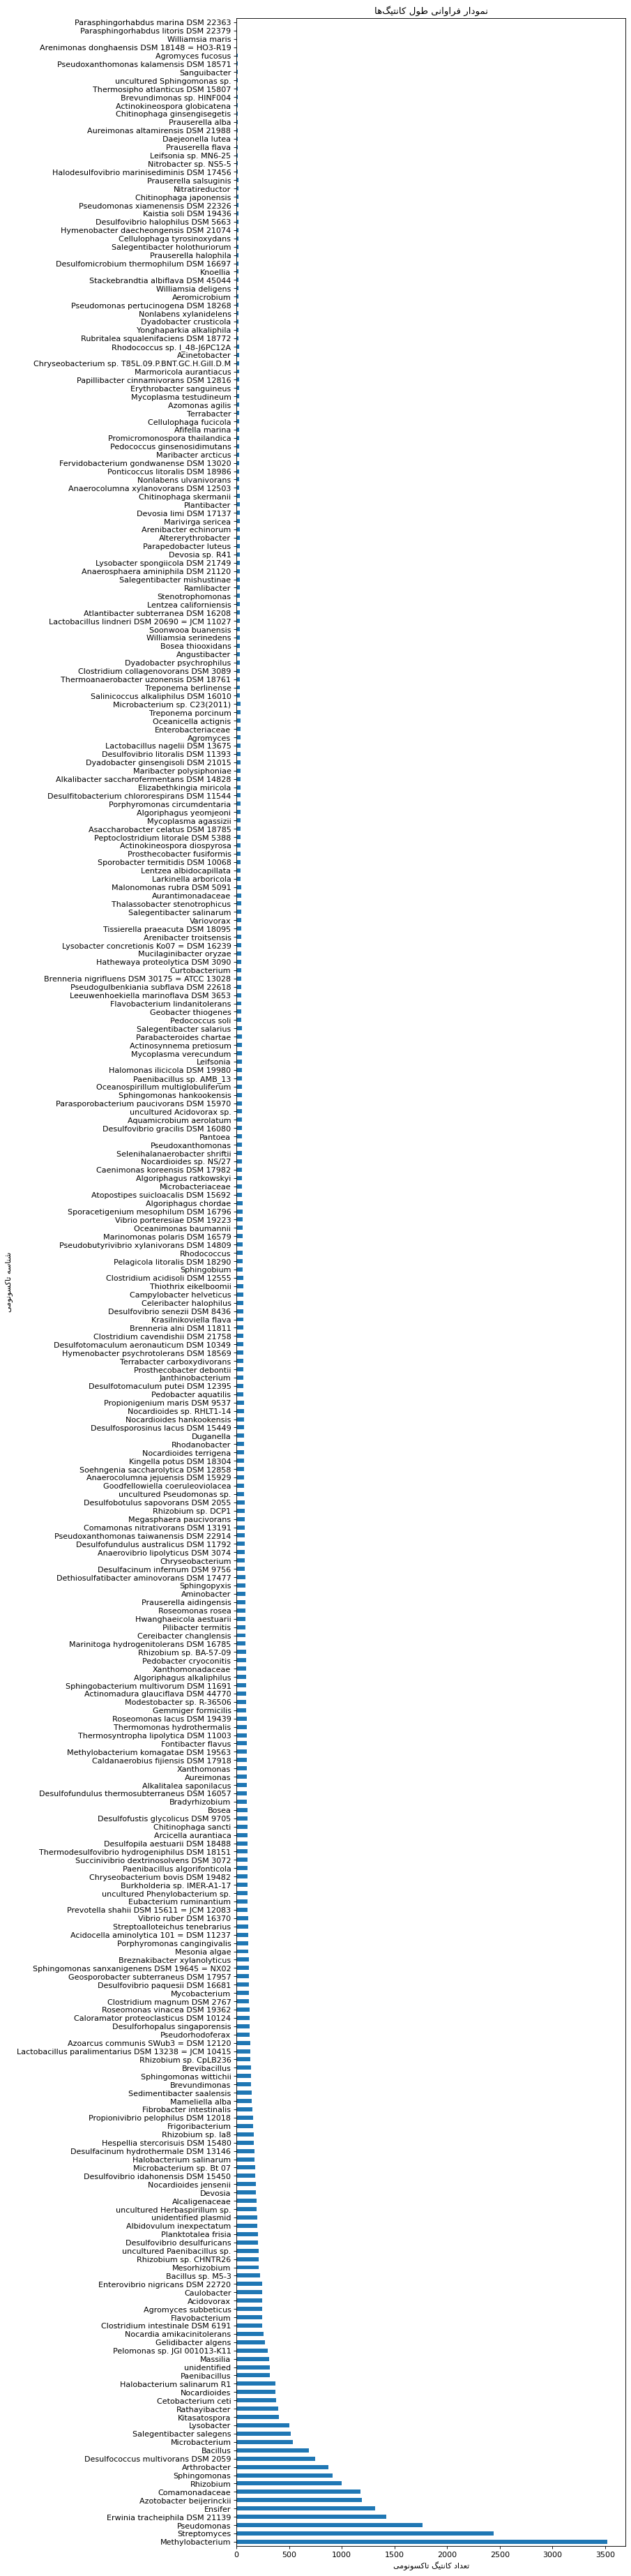

In [131]:
# show contig frequancy for every genome.
freq = contigs['tax_id'].value_counts()
#tax_names = [getTaxName(i)['ScientificName'] for i in freq.index]
plt.figure(num=None, figsize=(9, len(tax_names)//5), dpi=80, facecolor='w', edgecolor='k')
freq = pd.Series(data=freq.values, index=tax_names)
ax = freq.plot(kind='barh');
plt.xlabel(fa("تعداد کانتیگ تاکسونومی"))
plt.ylabel(fa("شناسه تاکسونومی"))
plt.title(fa("نمودار فراوانی طول کانتیگ‌ها"))

plt.savefig(f"./Output/{dataset_name}/figs/taxonomy_frequency.svg", bbox_inches='tight',dpi=100)
plt.savefig(f"./Output/{dataset_name}/figs/taxonomy_frequency.png", bbox_inches='tight',dpi=100)
plt.show()

# Abundances
##  superkingdom | phylum | class | order | family | genus | species | strain

In [149]:
# use this cell if your gold standard file needs to convert tsv format
'''with open('./Dataset/CAMI_High/goldstandard_high_pool.profile','r') as file:
    text = file.read()
    text = text.split('\n')
df = pd.read_csv(StringIO('\n'.join(text[5:])), sep="\t", header=None)                
df.columns = ['tax_id', 'rank', 'tax_path', 'tax_pathsn', 'percentage', 'genome_id', 'OTU']
df.to_csv('./Dataset/CAMI_High/abundances.tsv',index=None,sep='\t')
df.head()''';

In [151]:
abundances = pd.read_csv(f"./Dataset/{dataset_name}/abundances.tsv", sep='\t')
abundances.head()

,tax_id,rank,tax_path,tax_pathsn,percentage,genome_id,OTU
0,2157.0,superkingdom,2157,Archaea,0.3353,NaN,NaN
1,2.0,superkingdom,2,Bacteria,28.2362,NaN,NaN
2,976.0,phylum,2|976,Bacteria|Bacteroidetes,2.9050,NaN,NaN
3,1224.0,phylum,2|1224,Bacteria|Proteobacteria,14.6433,NaN,NaN
4,203691.0,phylum,2|203691,Bacteria|Spirochaetes,0.1037,NaN,NaN


In [157]:
abundances['rank'].value_counts()

strain          1074
species          243
genus            194
family            88
order             40
class             21
phylum            12
superkingdom       2
Name: rank, dtype: int64

In [158]:
sum(abundances[abundances['rank']=="strain"]['percentage'])

99.99949999999997

In [105]:
genome2freq = {}
for genome in abundances['genome_id'].unique():
    data = abundances[abundances['genome_id']==genome]        
    freq = data.iloc[0,:]['freq']
    genome2freq[genome] = freq
genome2freq = dict(sorted(genome2freq.items(), key=lambda item: item[1]))

In [106]:
list(genome2freq.keys())[0]

658085.1

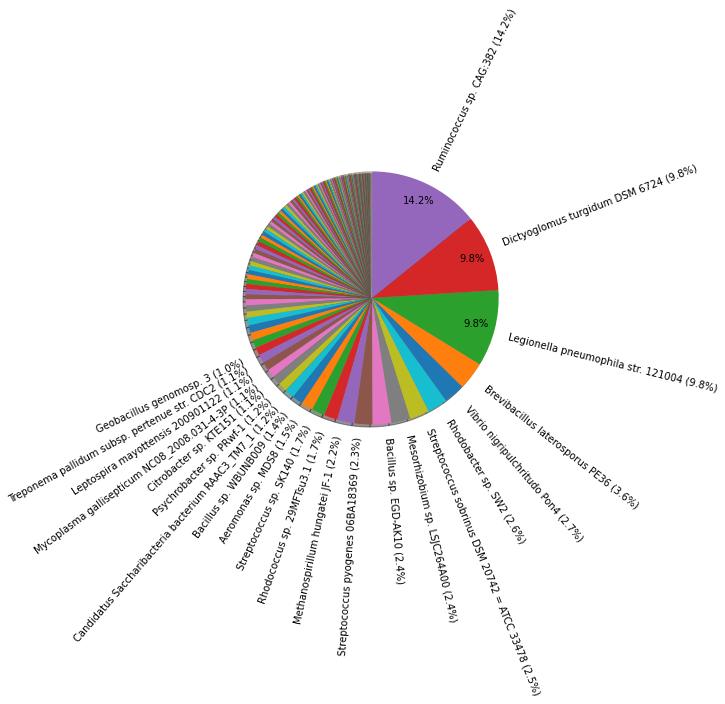

In [108]:
def my_autopct(pct):
    if(pct >= 5):
        return '%.1f' % pct + '%'
    return ''
    
s = sum(genome2freq.values())
labels = []
for key,value in genome2freq.items():
    if( value > s * 0.01):               
        pct = ' '
        pct = str(round(value/s*100,1)) + "%"
        labels.append(getTaxName(key)['ScientificName']+ f' ({pct})')
    else:
        labels.append('')
sizes = genome2freq.values()
explode = [0 for _ in range(len(sizes))]
plt.figure(num=None,figsize=(5,5))
ax = plt.gca()
ax.pie(sizes, explode=explode, labels=labels, autopct=my_autopct,
        shadow=True, startangle=90,rotatelabels=True,pctdistance=0.85)
ax.axis('equal')  
plt.savefig(f"./Output/{dataset_name}/figs/bactria_frequency_pie.svg")
plt.show()

# Gene Ontology

In [16]:
go = pd.read_csv(f"./Annotation/{dataset_name}/cds.gene2go.tab.txt", sep='\t')
print(f'gene2go table shape is : {go.shape}')
print(f'The number of contigs to which a GO term assigned is : {len(go["Contig"].unique())}')
print(f'The number of unique GO term assigned is : {len(go["go_id"].unique())}')
print(f"median : {np.median(list(go['go_id'].value_counts()))}")
go.head(2)

gene2go table shape is : (414303, 10)
The number of contigs to which a GO term assigned is : 70316
The number of unique GO term assigned is : 6840
median : 7.0


,#Gene,Contig,Start,End,Gene_Length,Strand,SP,TM,go_id,Taxonomy
metaerg.pl|00002,RL|S1|C13963,1160,2104,945,1,No,0,GO:0016811,"hydrolase activity, acting on carbon-nitrogen ...",d__Bacteria;p__Actinobacteriota;c__Actinobacte...
metaerg.pl|00002,RL|S1|C13963,1160,2104,945,1,No,0,GO:0019740,nitrogen utilization,d__Bacteria;p__Actinobacteriota;c__Actinobacte...


In [ ]:
linewidth = 4
plt.figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(list(go['go_id'].value_counts()),linewidth=linewidth)
plt.title('show GO frequency number')
plt.savefig(f"./Output/{dataset_name}/figs/GO_frequency_number.svg")
plt.savefig(f"./Output/{dataset_name}/figs/GO_frequency_number.png")
plt.show()

In [ ]:
plt.figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(list(go['go_id'].value_counts()[:100]),linewidth=linewidth)
plt.title('show first 100 GO frequency number')
plt.savefig(f"./Output/{dataset_name}/figs/first_100_GO_frequency_number.svg")
plt.savefig(f"./Output/{dataset_name}/figs/first_100_GO_frequency_number.png")
plt.show()

# for ariways, urog,....

In [40]:
with open(f"./Dataset/{dataset_name}/contigs.fna", 'r') as file:
    lines = [line for line in file.read().split('\n') if len(line) > 0]
ids = []
contigs = []
s = ''
for l in lines:
    if(l[0]=='>'):
        ids.append(l)        
        contigs.append(s)
        s = ''
    else:
        s += l    
contigs.append(s)
contigs = contigs[1:]

contigs = pd.DataFrame(
        {
            '#anonymous_gsa_id': ids,
            'contig': contigs
        },
columns=['#anonymous_gsa_id', 'contig'])
contigs['#anonymous_gsa_id'] = contigs['#anonymous_gsa_id'].apply(lambda x: x[1:])
del(lines)
contigs.head(2)

,#anonymous_gsa_id,contig
0,S4C8,GTTATAATTTCCCGGCTGGATCTCCTTGAAATCATCAGACAAAATA...
1,S4C16,CGAGCAAACGAAGGCCGTACTAGAGATTCAGGCCAAGTGGAAGACT...


In [41]:
info = pd.read_csv(f"./Dataset/{dataset_name}/reference.tsv", sep='\t',header=None)
info.columns = ['#anonymous_gsa_id','OTU','Genbank Accession Number','a','b']

df = pd.read_csv(f"./Dataset/{dataset_name}/taxonomy.tsv", sep='\t',header=None)
df.columns=['OTU','Bacteria','Family']
info = pd.merge(info, df, how='inner', on='OTU')

contigs = pd.merge(contigs, info, how='inner', on='#anonymous_gsa_id')
contigs.head(2)

,#anonymous_gsa_id,contig,OTU,Genbank Accession Number,a,b,Bacteria,Family
0,S4C8,GTTATAATTTCCCGGCTGGATCTCCTTGAAATCATCAGACAAAATA...,OTU_97.38219.0,CP015399.1,2449858,2453454,Lachnoclostridium sp. YL32,Lachnoclostridium
1,S4C16,CGAGCAAACGAAGGCCGTACTAGAGATTCAGGCCAAGTGGAAGACT...,OTU_97.20930.0,AE015924.1,1271118,1273294,Porphyromonas gingivalis,Porphyromonas


In [42]:
with np.load(f'./Dataset/{dataset_name}/abundance_old.npz') as data:
    d = data['arr_0']

In [43]:
df = contigs[contigs['OTU']=='OTU_97.38219.0']
print(df['contig'].apply(lambda x : len(x))[0])
df['a']

3597


0        2449858
18        590051
32        515869
35        739586
39       1860743
          ...   
30077    5294689
30082    1570684
30083    5855839
30085    5026205
30114    4840049
Name: a, Length: 1296, dtype: int64

In [44]:
sum(d[contigs[contigs['OTU']=='OTU_97.38219.0'].index,:])

array([2.6883471e-01, 2.6423633e-02, 1.5357387e+00, 3.3737370e-01,
       2.4609092e-01, 3.3989871e+00, 2.1431597e+03, 9.8478489e+00,
       4.1099778e-01, 1.6016455e+00], dtype=float32)

In [45]:
with np.load(f'./Dataset/{dataset_name}/abundance.npz') as data:
    d = data['arr_0']

In [46]:
d[2,:]

array([0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 2.35598,
       0.     , 0.     , 0.     ], dtype=float32)

In [93]:
bactria2freq = {}
for bactria in contigs['Bacteria'].unique():
    data = contigs[contigs['Bacteria']==bactria]        
    freq = data.iloc[0,:]['freq']
    bactria2freq[bactria] = freq
bactria2freq = dict(sorted(bactria2freq.items(), key=lambda item: item[1]))

KeyError: 'freq'

In [ ]:
def my_autopct(pct):
    return ('%.1f' % pct) if pct > 5 else ''
s = sum(genome2freq.values())
labels = []
for key,value in genome2freq.items():
    if( value > s * 0.05):
        labels.append(key)
    else:
        labels.append('')
sizes = genome2freq.values()#[15, 30, 45, 10]
explode = [0 for _ in range(len(sizes))]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct=my_autopct,
        shadow=True, startangle=90)
ax1.axis('equal')  
plt.show()

# Show statistic result

In [112]:
# show description of contigs and contigs length histogram.
contigsLenght = contigs['contig'].apply(lambda x: len(x))
print(f'contigs number :  {contigs.shape[0]}')
try:
    print(f"number of genomes:  {len(contigs['genome_id'].unique())}")
except:
    print(f"number of genomes:  {len(contigs['Bacteria'].unique())}")
print(f'min : {contigsLenght.min()}')
print(f'max : {contigsLenght.max()}')
print(f'mean : {round(contigsLenght.mean(),2)}')
print(f'median : {round(np.median(contigsLenght),2)}')
print(f'1st quartiles : {round(np.percentile(contigsLenght, 25),2)}')
print(f'median : {round(np.median(contigsLenght),2)}')
print(f'3rd quartiles : {round(np.percentile(contigsLenght, 75),2)}')
print(f'standard deviation : {round(np.std(contigsLenght),2)}')
print(f'variance : {round(np.var(contigsLenght),2)}')

contigs number :  187685
number of genomes:  266
min : 2000
max : 6186826
mean : 8812.49
median : 3286.0
1st quartiles : 2460.0
median : 3286.0
3rd quartiles : 5233.0
standard deviation : 90102.75
variance : 8118505497.41
